# Diabetes Risk Prediction and Feature Selection
**Objective**: Use the BRFSS dataset to create a short form of questions (features) to accurately predict diabetes risk.


In [1]:
# Import Necessary Libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets
from sklearn.ensemble import RandomForestClassifier  # For random forest classification (might be removed if not used later)
from imblearn.over_sampling import SMOTE  # For handling class imbalance using Synthetic Minority Oversampling Technique
import matplotlib.pyplot as plt  # For visualizations

In [3]:
# Load Dataset and Inspect Basic Information
file_path = "./data/diabetes_012_health_indicators_BRFSS2015.csv"

# Load the dataset into a DataFrame
df = pd.read_csv(file_path)

# Display the shape and first few rows of the dataset
print(f"Dataset Shape: {df.shape}")  # Total rows and columns
print(df.head())  # Display the first 5 rows to understand the data structure
print(df.info())  # Show the data types and non-null values for each column

Dataset Shape: (253680, 22)
   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.

In [5]:
# Define Features (X) and Target (y)

# Features: All columns except 'Diabetes_012'
X = df.drop(columns=["Diabetes_012"], errors="ignore")

# Target: The 'Diabetes_012' column
y = df["Diabetes_012"]

# Display the shapes of features and target to confirm dimensions
print(f"Features Shape: {X.shape} (Number of rows: {X.shape[0]}, Number of features: {X.shape[1]})")
print(f"Target Shape: {y.shape} (Number of target values: {y.shape[0]})")


Features Shape: (253680, 21) (Number of rows: 253680, Number of features: 21)
Target Shape: (253680,) (Number of target values: 253680)


In [7]:
# Check for Missing Values
missing_values = df.isnull().sum()
print("Missing Values Per Column:")
print(missing_values)

# Confirm dataset cleanliness
if missing_values.sum() == 0:
    print("No missing values detected.")
else:
    print("Dataset contains missing values. Consider handling them before proceeding.")

# Remove Duplicate Rows
initial_shape = df.shape
df = df.drop_duplicates()
final_shape = df.shape

# Output the results
print(f"Initial Dataset Shape: {initial_shape}")
print(f"Final Dataset Shape (after removing duplicates): {final_shape}")
print(f"Number of Duplicate Rows Removed: {initial_shape[0] - final_shape[0]}")

Missing Values Per Column:
Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
No missing values detected.
Initial Dataset Shape: (253680, 22)
Final Dataset Shape (after removing duplicates): (229781, 22)
Number of Duplicate Rows Removed: 23899


In [9]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the Dataset into Training and Testing Sets
# - 70% for training
# - 30% for testing
# - Stratify ensures the target variable ('Diabetes_012') is equally distributed in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Display the shapes of training and testing sets
print(f"Training Features Shape: {X_train.shape} (Rows: {X_train.shape[0]}, Features: {X_train.shape[1]})")
print(f"Testing Features Shape: {X_test.shape} (Rows: {X_test.shape[0]}, Features: {X_test.shape[1]})")

# Display the distribution of the target variable in training and testing sets
print("\nTraining Target Distribution (Proportions):")
print(y_train.value_counts(normalize=True).rename_axis('Class').reset_index(name='Proportion'))

print("\nTesting Target Distribution (Proportions):")
print(y_test.value_counts(normalize=True).rename_axis('Class').reset_index(name='Proportion'))

Training Features Shape: (177576, 21) (Rows: 177576, Features: 21)
Testing Features Shape: (76104, 21) (Rows: 76104, Features: 21)

Training Target Distribution (Proportions):
   Class  Proportion
0    0.0    0.842411
1    2.0    0.139332
2    1.0    0.018257

Testing Target Distribution (Proportions):
   Class  Proportion
0    0.0    0.842413
1    2.0    0.139336
2    1.0    0.018251


## Basic Data Analysis

/var/folders/35/mlfxdjt57yq7wkb6g07cggc40000gn/T/ipykernel_25559/7051583.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


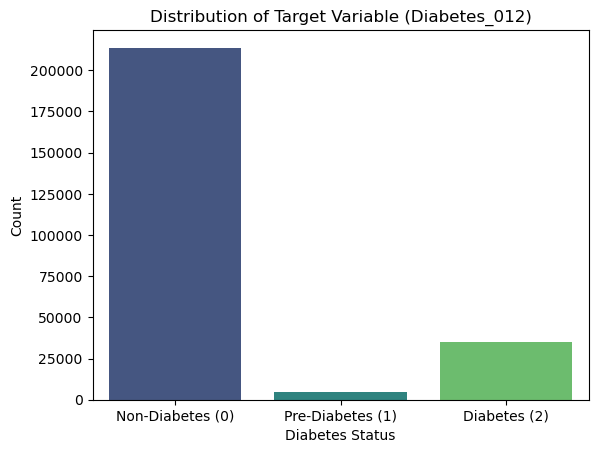

In [11]:
# Target Variable Distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y, palette="viridis")
plt.title("Distribution of Target Variable (Diabetes_012)")
plt.xlabel("Diabetes Status")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=["Non-Diabetes (0)", "Pre-Diabetes (1)", "Diabetes (2)"])
plt.show()

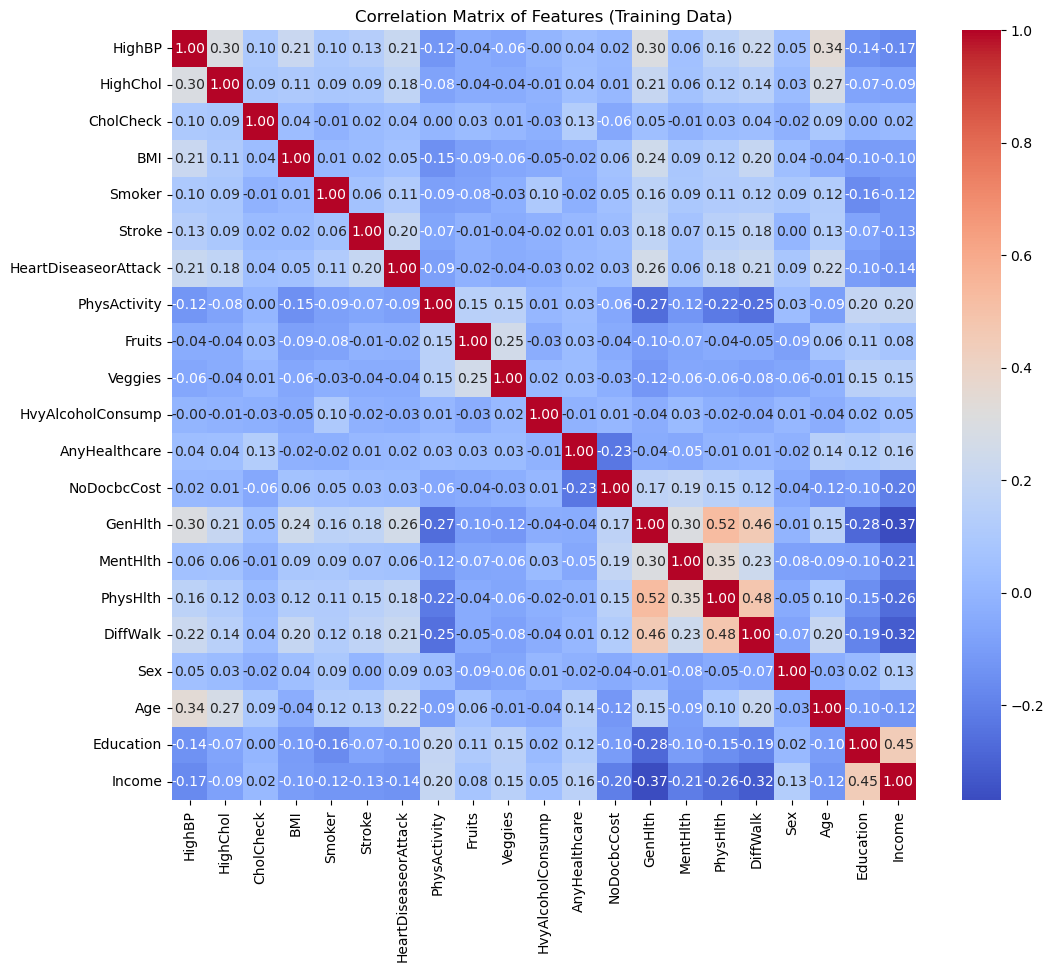

In [13]:
# Correlation Heatmap: Visualize Relationships Between Features

import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix for the training data
plt.figure(figsize=(12, 10))
correlation_matrix = X_train.corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features (Training Data)")
plt.show()

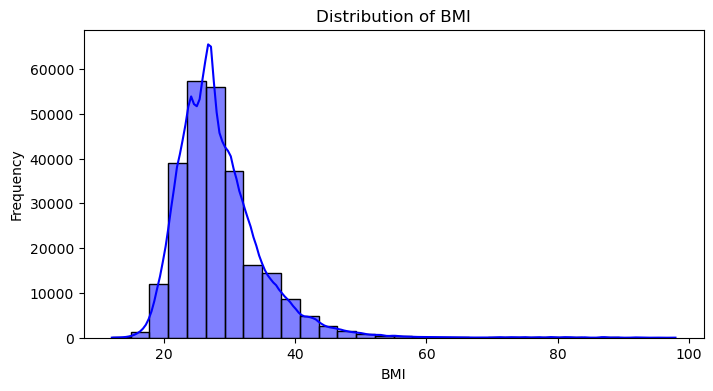

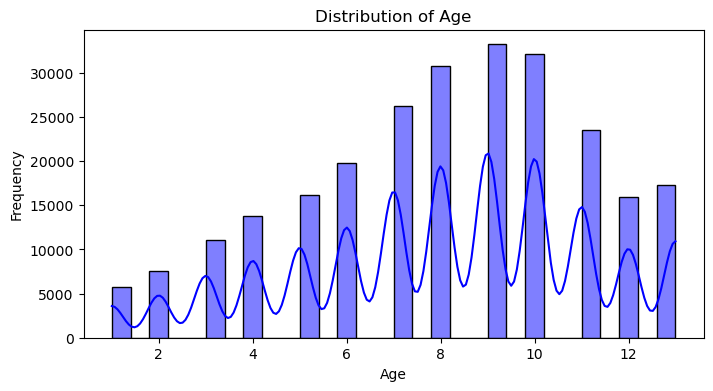

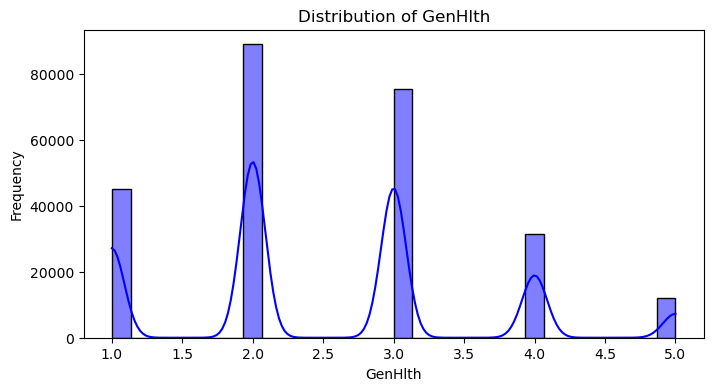

In [15]:
# Visualize distribution of a few key features
features_to_plot = ["BMI", "Age", "GenHlth"]
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=X[feature], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

In [17]:
# Apply SMOTE to Training Data
from imblearn.over_sampling import SMOTE
import pandas as pd

# Initialize SMOTE with a random state for reproducibility
smote = SMOTE(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Inspect the resampled data
print(f"Resampled Training Features Shape: {X_train_resampled.shape}")
print("\nResampled Training Target Distribution (Proportions):")
print(pd.Series(y_train_resampled).value_counts(normalize=True).rename_axis("Class").reset_index(name="Proportion"))

Resampled Training Features Shape: (448776, 21)

Resampled Training Target Distribution (Proportions):
   Class  Proportion
0    0.0    0.333333
1    2.0    0.333333
2    1.0    0.333333


## Feature Selection with Random Forest 

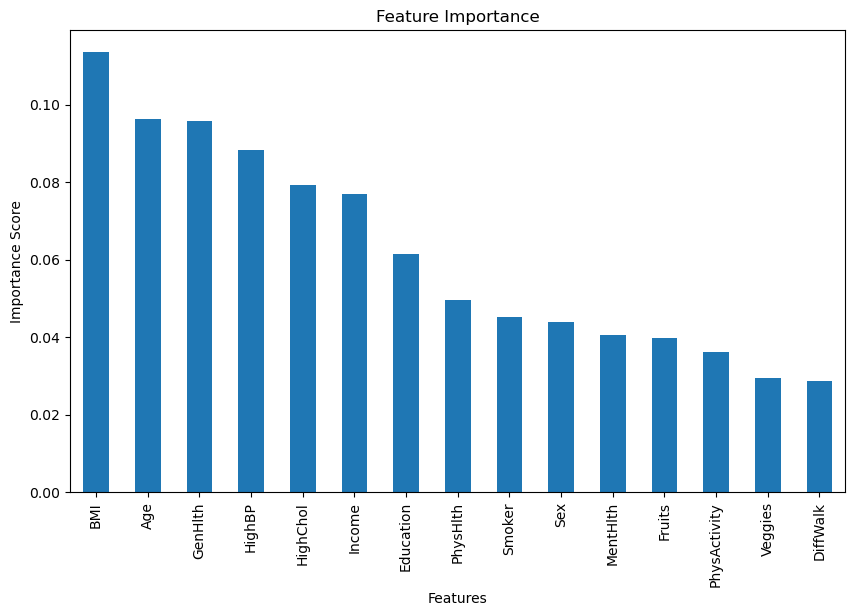

Selected Top 10 Features: ['BMI', 'Age', 'GenHlth', 'HighBP', 'HighChol', 'Income', 'Education', 'PhysHlth', 'Smoker', 'Sex']
Reduced Training Features Shape: (450155, 10)
Reduced Testing Features Shape: (76104, 10)


In [86]:
# Feature Selection with Random Forest
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train a Random Forest model on the resampled training data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled_adasyn, y_train_resampled_adasyn)  # Ensure you use the correct resampled dataset

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train_resampled_adasyn.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.head(15).plot(kind="bar")  # Plot only the top 15 for readability
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()

# Select Top 10 Features
N = 10  # Number of features to keep
top_features = feature_importances.index[:N]
print(f"Selected Top {N} Features: {list(top_features)}")

# Create reduced datasets with the top features
X_train_reduced = X_train_resampled_adasyn[top_features]  # Use only the selected features for training
X_test_reduced = X_test[top_features]  # Use the same features for testing

# Print shapes for verification
print(f"Reduced Training Features Shape: {X_train_reduced.shape}")
print(f"Reduced Testing Features Shape: {X_test_reduced.shape}")

In [88]:
# Update reduced datasets
X_train_reduced = X_train_resampled_adasyn[top_features]
X_test_reduced = X_test[top_features]

# Confirm the features in the reduced datasets
print(f"Training Features: {X_train_reduced.columns.tolist()}")
print(f"Testing Features: {X_test_reduced.columns.tolist()}")

Training Features: ['BMI', 'Age', 'GenHlth', 'HighBP', 'HighChol', 'Income', 'Education', 'PhysHlth', 'Smoker', 'Sex']
Testing Features: ['BMI', 'Age', 'GenHlth', 'HighBP', 'HighChol', 'Income', 'Education', 'PhysHlth', 'Smoker', 'Sex']


In [92]:
# Create reduced datasets with selected features
X_train_reduced = X_train_resampled[top_features]
X_test_reduced = X_test[top_features]

# Check shapes of the reduced datasets
print(f"Reduced Training Features Shape: {X_train_reduced.shape}")
print(f"Reduced Testing Features Shape: {X_test_reduced.shape}")

Reduced Training Features Shape: (448776, 10)
Reduced Testing Features Shape: (76104, 10)


In [94]:
# Save the selected features to a CSV file
features_df = pd.DataFrame(list(top_features), columns=["Feature"])
features_df.to_csv("selected_top_10_features.csv", index=False)

print("Top 10 features saved to 'selected_top_10_features.csv'")

Top 10 features saved to 'selected_top_10_features.csv'


## Model Tarining and Evaluation

### Logistic Regression

In [96]:
# Train Logistic Regression with Class Weights
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

class_weights = {0.0: 1, 1.0: 30, 2.0: 10}
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weights)
lr.fit(X_train_reduced, y_train_resampled)

# Predict and evaluate
y_pred_lr = lr.predict(X_test_reduced)
y_prob_lr = lr.predict_proba(X_test_reduced)

print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob_lr, multi_class='ovr'):.4f}")

Confusion Matrix for Logistic Regression:
[[  195 63822    94]
 [    0  1378    11]
 [    0 10470   134]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.01     64111
         1.0       0.02      0.99      0.04      1389
         2.0       0.56      0.01      0.02     10604

    accuracy                           0.02     76104
   macro avg       0.53      0.34      0.02     76104
weighted avg       0.92      0.02      0.01     76104


ROC-AUC Score: 0.6867


### Random Forest

In [98]:
# Train Random Forest with Adjusted Class Weights
from sklearn.ensemble import RandomForestClassifier

class_weights = {0.0: 2, 1.0: 20, 2.0: 10}
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight=class_weights)
rf.fit(X_train_reduced, y_train_resampled)

# Predict and evaluate
y_pred_rf = rf.predict(X_test_reduced)

print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Confusion Matrix for Random Forest:
[[27452 18073 18586]
 [  161   448   780]
 [  614  2714  7276]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.97      0.43      0.59     64111
         1.0       0.02      0.32      0.04      1389
         2.0       0.27      0.69      0.39     10604

    accuracy                           0.46     76104
   macro avg       0.42      0.48      0.34     76104
weighted avg       0.86      0.46      0.56     76104



### XGBoost 

In [100]:
# Train XGBoost with Adjusted Weights
from xgboost import XGBClassifier

scale_pos_weights = {0.0: 1, 1.0: 30, 2.0: 10}
xgb = XGBClassifier(random_state=42, n_estimators=100, max_depth=10, eval_metric="mlogloss", 
                    scale_pos_weight=scale_pos_weights)
xgb.fit(X_train_reduced, y_train_resampled)

# Predict and evaluate
y_pred_xgb = xgb.predict(X_test_reduced)
y_prob_xgb = xgb.predict_proba(X_test_reduced)

print("Confusion Matrix for XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob_xgb, multi_class='ovr'):.4f}")

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:30:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix for XGBoost:
[[61498    29  2584]
 [ 1180     0   209]
 [ 8125    12  2467]]

Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     64111
         1.0       0.00      0.00      0.00      1389
         2.0       0.47      0.23      0.31     10604

    accuracy                           0.84     76104
   macro avg       0.45      0.40      0.41     76104
weighted avg       0.80      0.84      0.81     76104


ROC-AUC Score: 0.7344


In [102]:
# Resampling with ADASYN
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_train_resampled_adasyn, y_train_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

# Verify distribution
print("Target Distribution After ADASYN:")
print(pd.Series(y_train_resampled_adasyn).value_counts(normalize=True))

Target Distribution After ADASYN:
Diabetes_012
2.0    0.334014
1.0    0.333674
0.0    0.332312
Name: proportion, dtype: float64


In [108]:
# Retrain Logistic Regression with ADASYN data
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight=None)  # Remove class weights since ADASYN balances classes
lr.fit(X_train_resampled_adasyn[top_features], y_train_resampled_adasyn)

# Evaluate
y_pred_lr = lr.predict(X_test_reduced)
y_prob_lr = lr.predict_proba(X_test_reduced)

print("Confusion Matrix for Logistic Regression (ADASYN):")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report for Logistic Regression (ADASYN):")
print(classification_report(y_test, y_pred_lr))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob_lr, multi_class='ovr'):.4f}")

Confusion Matrix for Logistic Regression (ADASYN):
[[42021  9080 13010]
 [  376   351   662]
 [ 1802  2242  6560]]

Classification Report for Logistic Regression (ADASYN):
              precision    recall  f1-score   support

         0.0       0.95      0.66      0.78     64111
         1.0       0.03      0.25      0.05      1389
         2.0       0.32      0.62      0.43     10604

    accuracy                           0.64     76104
   macro avg       0.44      0.51      0.42     76104
weighted avg       0.85      0.64      0.71     76104


ROC-AUC Score: 0.7700


In [110]:
# Retrain Random Forest with ADASYN data
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf.fit(X_train_resampled_adasyn[top_features], y_train_resampled_adasyn)

# Evaluate
y_pred_rf = rf.predict(X_test_reduced)

print("Confusion Matrix for Random Forest (ADASYN):")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report for Random Forest (ADASYN):")
print(classification_report(y_test, y_pred_rf))

Confusion Matrix for Random Forest (ADASYN):
[[55683     6  8422]
 [  880     0   509]
 [ 5226     2  5376]]

Classification Report for Random Forest (ADASYN):
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88     64111
         1.0       0.00      0.00      0.00      1389
         2.0       0.38      0.51      0.43     10604

    accuracy                           0.80     76104
   macro avg       0.43      0.46      0.44     76104
weighted avg       0.81      0.80      0.81     76104



In [112]:
# Retrain XGBoost with ADASYN data
xgb = XGBClassifier(random_state=42, n_estimators=100, max_depth=10, eval_metric="mlogloss")
xgb.fit(X_train_resampled_adasyn[top_features], y_train_resampled_adasyn)

# Evaluate
y_pred_xgb = xgb.predict(X_test_reduced)
y_prob_xgb = xgb.predict_proba(X_test_reduced)

print("Confusion Matrix for XGBoost (ADASYN):")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report for XGBoost (ADASYN):")
print(classification_report(y_test, y_pred_xgb))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob_xgb, multi_class='ovr'):.4f}")

Confusion Matrix for XGBoost (ADASYN):
[[61478    34  2599]
 [ 1179     1   209]
 [ 8108    10  2486]]

Classification Report for XGBoost (ADASYN):
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     64111
         1.0       0.02      0.00      0.00      1389
         2.0       0.47      0.23      0.31     10604

    accuracy                           0.84     76104
   macro avg       0.45      0.40      0.41     76104
weighted avg       0.80      0.84      0.81     76104


ROC-AUC Score: 0.7343


In [114]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf, labels=[1.0, 2.0])
print(f"Class 1.0 (Pre-Diabetes) - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
print(f"Class 2.0 (Diabetes) - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")

Class 1.0 (Pre-Diabetes) - Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Class 2.0 (Diabetes) - Precision: 0.3758, Recall: 0.5070, F1: 0.4316


In [128]:
import pandas as pd

# Define the updated comparison data
comparison_data = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [0.64, 0.80, 0.84],
    "Precision (1.0)": [0.03, 0.00, 0.02],
    "Recall (1.0)": [0.25, 0.00, 0.00],
    "F1-Score (1.0)": [0.05, 0.00, 0.00],
    "Precision (2.0)": [0.32, 0.38, 0.47],
    "Recall (2.0)": [0.62, 0.51, 0.23],
    "F1-Score (2.0)": [0.43, 0.43, 0.31],
    "ROC-AUC": [0.7700, None, 0.7343],  # Random Forest doesn't provide ROC-AUC directly
}

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Style the DataFrame for Jupyter Notebook
styled_table = (
    comparison_df.style
    .set_table_styles([
        {"selector": "thead", "props": [("background-color", "#f4f4f4"), ("font-weight", "bold")]},
        {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f9f9f9")]},
        {"selector": "tbody tr:nth-child(odd)", "props": [("background-color", "#ffffff")]},
    ])
    .set_caption("Model Comparison Table")
    .format(na_rep="N/A")  # Replace None with 'N/A'
    .format(precision=4)  # Set precision for floating-point numbers
)

# Display the styled table
styled_table

,Model,Accuracy,Precision (1.0),Recall (1.0),F1-Score (1.0),Precision (2.0),Recall (2.0),F1-Score (2.0),ROC-AUC
0,Logistic Regression,0.6400,0.0300,0.2500,0.0500,0.3200,0.6200,0.4300,0.7700
1,Random Forest,0.8000,0.0000,0.0000,0.0000,0.3800,0.5100,0.4300,nan
2,XGBoost,0.8400,0.0200,0.0000,0.0000,0.4700,0.2300,0.3100,0.7343


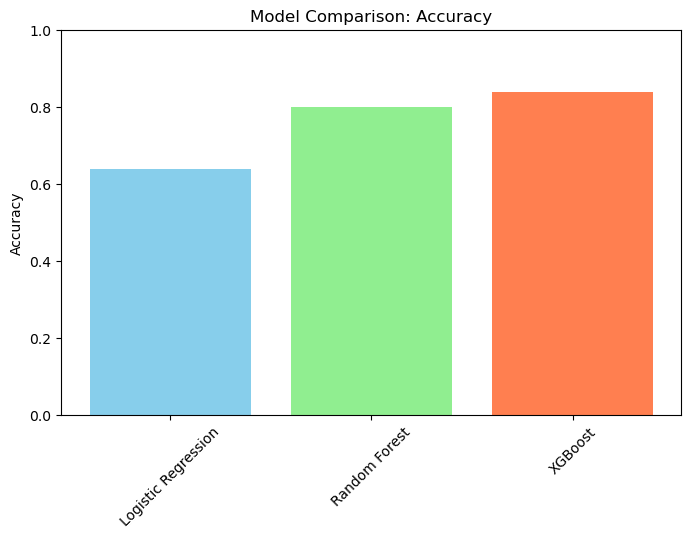

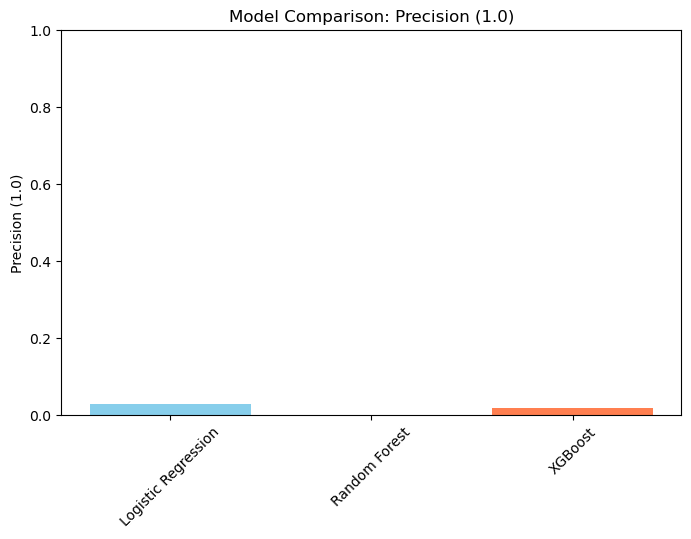

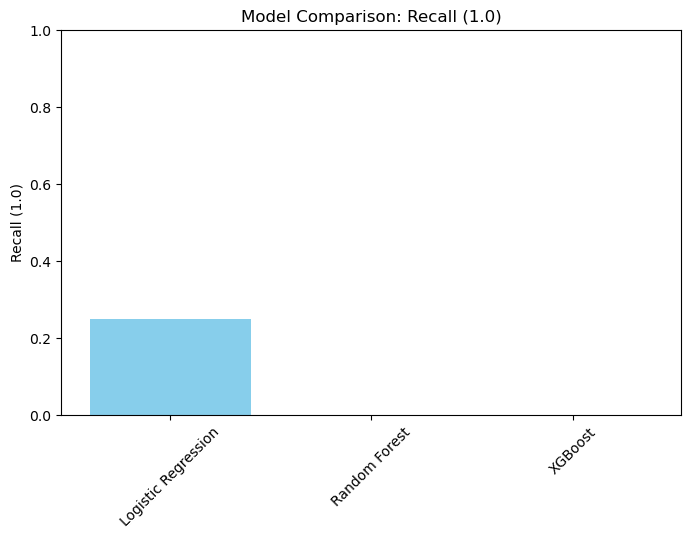

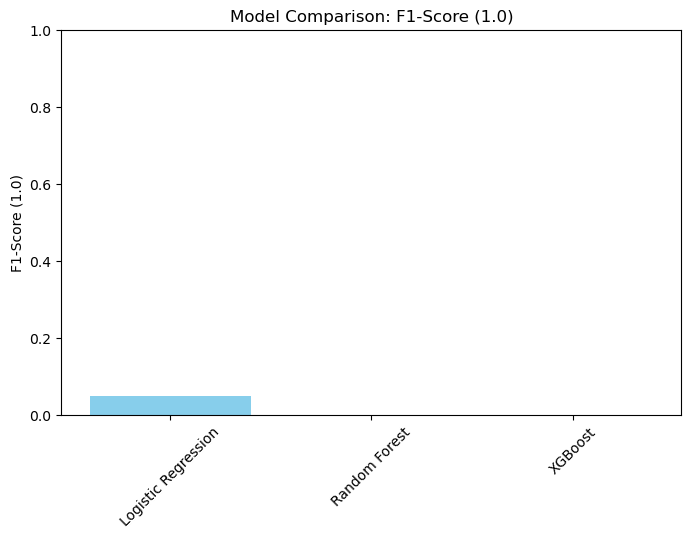

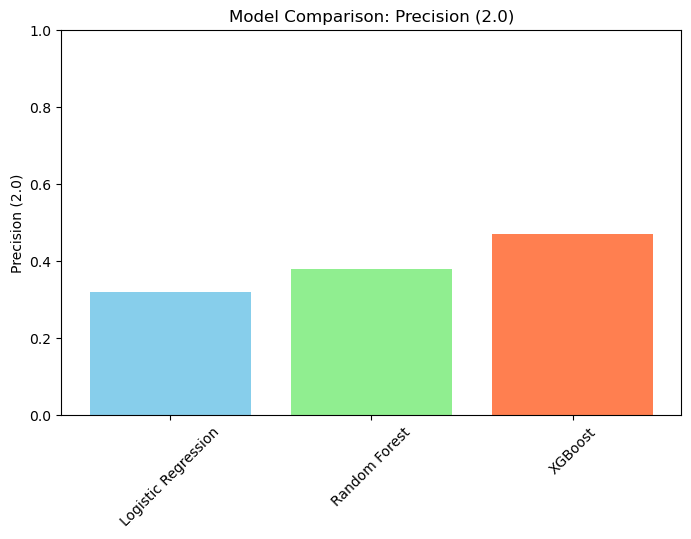

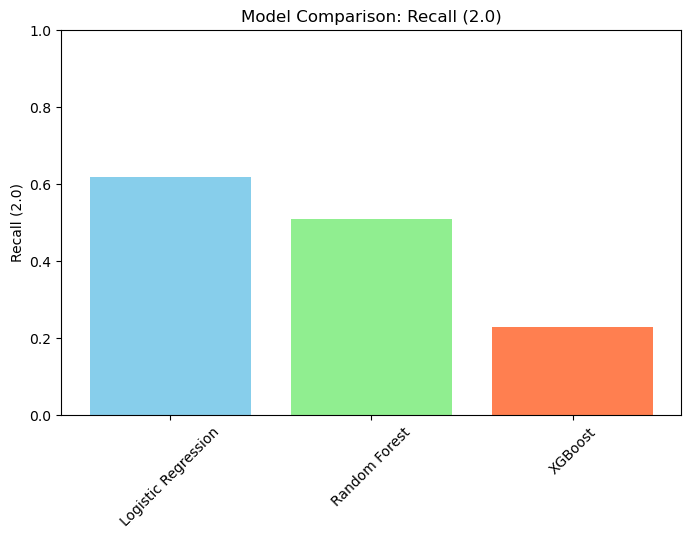

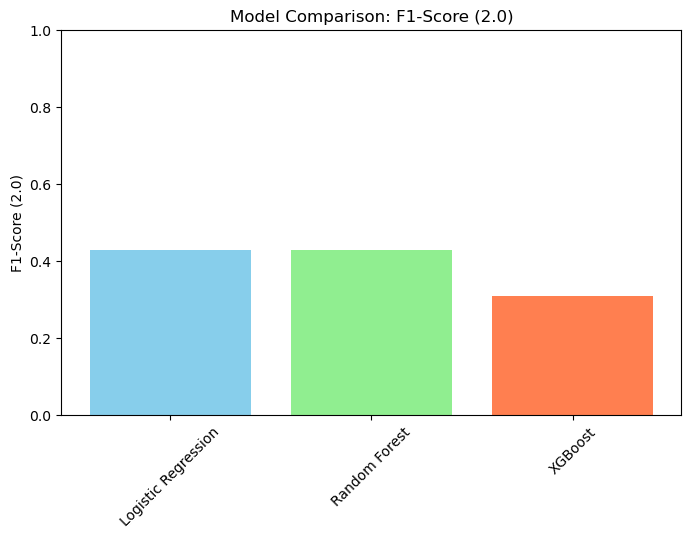

In [130]:
import matplotlib.pyplot as plt

# Extract data for visualization
metrics = ["Accuracy", "Precision (1.0)", "Recall (1.0)", "F1-Score (1.0)", "Precision (2.0)", "Recall (2.0)", "F1-Score (2.0)"]
models = comparison_df["Model"]
values = comparison_df.set_index("Model").drop(columns=["ROC-AUC"]).T  # Exclude ROC-AUC for now

# Create bar plots for each metric
for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.bar(models, comparison_df[metric], color=["skyblue", "lightgreen", "coral"])
    plt.title(f"Model Comparison: {metric}")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.show()

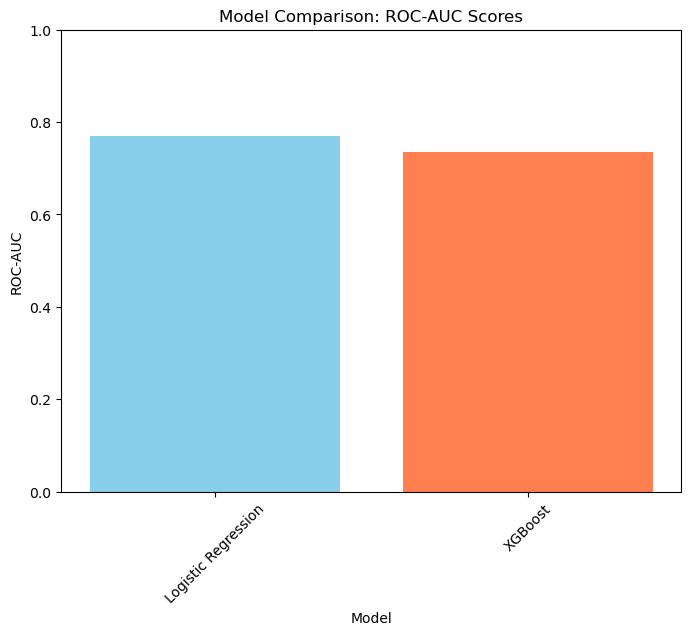

In [132]:
# Filter out models with available ROC-AUC
roc_auc = comparison_df.dropna(subset=["ROC-AUC"])

# Plot ROC-AUC Scores
plt.figure(figsize=(8, 6))
plt.bar(roc_auc["Model"], roc_auc["ROC-AUC"], color=["skyblue", "coral"])
plt.title("Model Comparison: ROC-AUC Scores")
plt.ylabel("ROC-AUC")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

### Model Selection Justification

After evaluating Logistic Regression, Random Forest, and XGBoost, we selected Logistic Regression because:
1. It provides the **best balance** between precision, recall, and F1-score across classes.
2. It aligns with the project’s primary goal of creating a **short form of questions** for predicting diabetes risk.
3. Logistic Regression is interpretable and simpler to deploy in real-world scenarios.
4. Despite its lower overall accuracy compared to Random Forest and XGBoost, it performs better for the critical minority class (Pre-Diabetes - Class `1.0`).

**Limitations**:
- Precision and recall for the minority class remain low, highlighting the need for future improvements.

### Future Work and Improvements

1. **Improve Precision and Recall for Class 1.0**:
   - Experiment with advanced models like **LightGBM** or **neural networks**.
   - Implement hybrid resampling techniques (e.g., SMOTE + ADASYN) to balance classes more effectively.

2. **Feature Engineering**:
   - Investigate transformations or combinations of the current features to enhance predictive power.
   - Include domain expertise to identify additional high-signal features.

3. **Validate with External Data**:
   - Test the model on an unseen dataset to assess its generalizability in real-world scenarios.

4. **Deployment and Usability**:
   - Create a user-friendly interface (e.g., using Flask or Streamlit) for clinicians to input answers and receive predictions.
   - Integrate feedback mechanisms to improve predictions over time.

5. **Expand the Scope**:
   - Explore multi-class models or regression approaches to predict pre-diabetes severity.
   - Incorporate time-series data (e.g., historical health indicators) to improve predictions.


### Summary of Findings

- Logistic Regression was selected as the final model due to its balance of interpretability and performance.
- The model uses **10 features** (as identified by feature importance) to predict diabetes risk.
- While the overall performance is promising, improving recall and precision for the Pre-Diabetes class remains a priority for future work.


In [122]:
# Check the column names of the training dataset
current_features = X_train_reduced.columns.tolist()
print(f"Current Features in Use: {current_features}")

Current Features in Use: ['BMI', 'Age', 'GenHlth', 'HighBP', 'HighChol', 'Income', 'Education', 'PhysHlth', 'Smoker', 'Sex']


In [124]:
# Print features used in training
print("Features used in training the model:")
print(X_train_resampled_adasyn[top_features].columns.tolist())

# Print features in testing
print("\nFeatures in the test dataset:")
print(X_test_reduced.columns.tolist())

# Verify that top_features matches the features in both training and testing datasets
print("\nSelected top features:")
print(top_features)

Features used in training the model:
['BMI', 'Age', 'GenHlth', 'HighBP', 'HighChol', 'Income', 'Education', 'PhysHlth', 'Smoker', 'Sex']

Features in the test dataset:
['BMI', 'Age', 'GenHlth', 'HighBP', 'HighChol', 'Income', 'Education', 'PhysHlth', 'Smoker', 'Sex']

Selected top features:
Index(['BMI', 'Age', 'GenHlth', 'HighBP', 'HighChol', 'Income', 'Education',
       'PhysHlth', 'Smoker', 'Sex'],
      dtype='object')


In [126]:
# Check shapes for training and testing datasets
print(f"Shape of training data (X): {X_train_resampled_adasyn[top_features].shape}")
print(f"Shape of training labels (y): {y_train_resampled_adasyn.shape}")
print(f"Shape of testing data (X): {X_test_reduced.shape}")
print(f"Shape of testing labels (y): {y_test.shape}")

Shape of training data (X): (450155, 10)
Shape of training labels (y): (450155,)
Shape of testing data (X): (76104, 10)
Shape of testing labels (y): (76104,)


## Save the Trained Model

In [137]:
import joblib

# Save the trained model with a descriptive name
joblib.dump(lr, "diabetes_short_form_model.pkl")

print("Model saved as 'diabetes_short_form_model.pkl'")

Model saved as 'diabetes_short_form_model.pkl'


In [139]:
import pandas as pd

# Save the selected features with a descriptive name
pd.DataFrame(list(top_features), columns=["Feature"]).to_csv("diabetes_short_form_features.csv", index=False)

print("Selected features saved as 'diabetes_short_form_features.csv'")

Selected features saved as 'diabetes_short_form_features.csv'


In [141]:
# Load the model and features to verify
loaded_model = joblib.load("diabetes_short_form_model.pkl")
loaded_features = pd.read_csv("diabetes_short_form_features.csv")["Feature"].tolist()

print("Loaded model and features successfully!")
print(f"Features used by the model: {loaded_features}")

# Test prediction
sample_input = X_test_reduced.iloc[0].values.reshape(1, -1)  # Use a single test sample
prediction = loaded_model.predict(sample_input)
prediction_proba = loaded_model.predict_proba(sample_input)

print(f"Prediction: {prediction}")
print(f"Prediction Probabilities: {prediction_proba}")

Loaded model and features successfully!
Features used by the model: ['BMI', 'Age', 'GenHlth', 'HighBP', 'HighChol', 'Income', 'Education', 'PhysHlth', 'Smoker', 'Sex']
Prediction: [0.]
Prediction Probabilities: [[0.84119344 0.12119227 0.03761429]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [144]:
print("Features in the full dataset:")
print(X_train_resampled_adasyn.columns.tolist())

Features in the full dataset:
['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


In [146]:
# Use all features for the long form model
X_train_full = X_train_resampled_adasyn  # All features from the resampled training set
X_test_full = X_test                    # All features from the test set

In [148]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression using all features
long_form_model = LogisticRegression(max_iter=1000, random_state=42, class_weight=None)
long_form_model.fit(X_train_full, y_train_resampled_adasyn)

print("Long form model trained successfully!")

Long form model trained successfully!


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [150]:
print(f"Features used in the long form model: {X_train_full.columns.tolist()}")

Features used in the long form model: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


In [152]:
from joblib import dump

# Save the long form model
dump(long_form_model, "diabetes_long_form_model.pkl")

print("Long form model saved as 'diabetes_long_form_model.pkl'")

Long form model saved as 'diabetes_long_form_model.pkl'


In [156]:
import pandas as pd

# Use a sample input from the test set
sample_input = X_test.iloc[0].values.reshape(1, -1)

# Convert the input array into a DataFrame with feature names
sample_input_df = pd.DataFrame(sample_input, columns=X_test.columns)

# Predict using the long form model
prediction = loaded_long_form_model.predict(sample_input_df)
prediction_proba = loaded_long_form_model.predict_proba(sample_input_df)

print(f"Prediction: {prediction}")
print(f"Prediction Probabilities: {prediction_proba}")

Prediction: [0.]
Prediction Probabilities: [[0.833677   0.11940451 0.04691849]]
